In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [5]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.7,
               'scale': .1,
               'delta': 1.11,
               'rho': .2,
              }
else:
     true_params = {'theta': 0.52, 
               'pi': -.12,
               'phi': -.1,
               'scale': 3.12,
               'delta': 0.27,
               'rho': .81,
              }
    
time_dim = 3700
sim_dim = 2000
innov_dim = 1000

## Setup the linking functions.

In [6]:
true_params['phi']

-0.1

In [7]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [8]:
# phi_val = .3
# true_params['equity_price']= vl.compute_theta(psi=total_true_params['psi'], scale=true_params['scale'],
#                                                              rho=true_params['rho'], zeta=1-phi_val**2)
# true_params['phi'] = phi_val
# print("Theta is {:.2f}".format(true_params['equity_price']))

In [9]:
total_true_params

{'theta': 0.52,
 'pi': -0.12,
 'phi': -0.1,
 'scale': 3.12,
 'delta': 0.27,
 'rho': 0.81,
 'gamma': 0.035201340784409195,
 'beta': 0.03365878069764182,
 'psi': -0.06188074457048909,
 'zeta': 0.99}

## We start by examining the distributions of simulated data

In [10]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

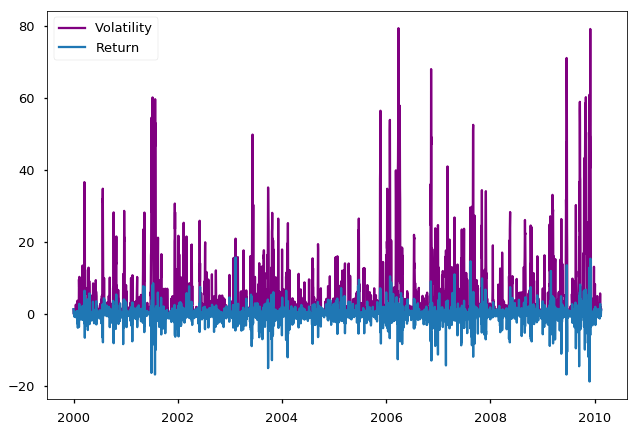

In [11]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.vol, label='Volatility', color='purple')
ax1.plot(data.rtn, label='Return')
ax1.legend()

In [12]:
data.cov()

,vol,rtn
vol,79.970442,-3.125518
rtn,-3.125518,4.832990


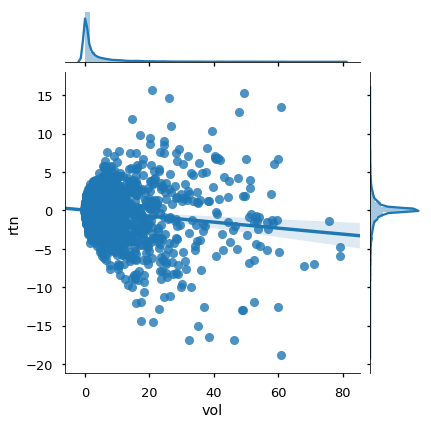

In [13]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [14]:
data.describe()

,vol,rtn
count,3.700000e+03,3700.000000
mean,4.369582e+00,-0.129667
std,8.942619e+00,2.198406
min,2.289053e-12,-18.826407
25%,5.513922e-02,-0.488788
50%,7.688455e-01,0.042479
75%,4.226114e+00,0.444948
max,7.934286e+01,15.630544


## I now estimate all of the parameters

In [15]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [16]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [17]:
%debug

No traceback has been produced, nothing to debug.


In [18]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(map(estimator, data_arr),
                                      total=len(data_arr)))

In [19]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [20]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

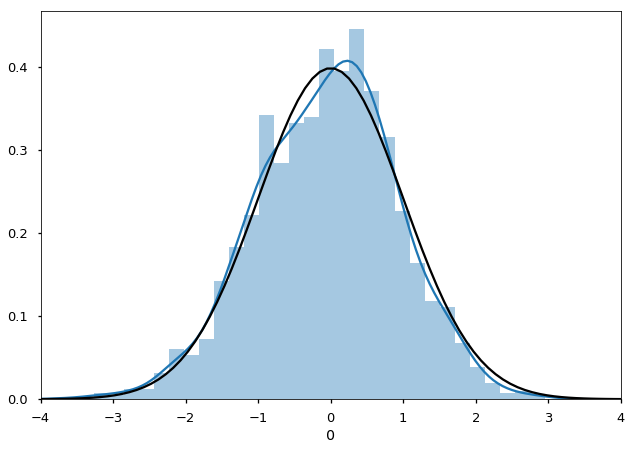

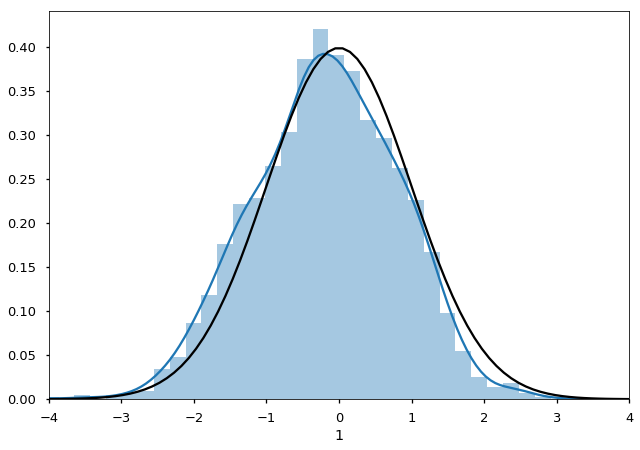

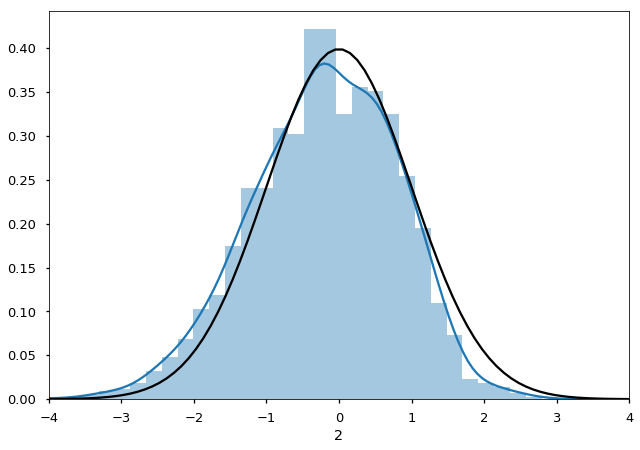

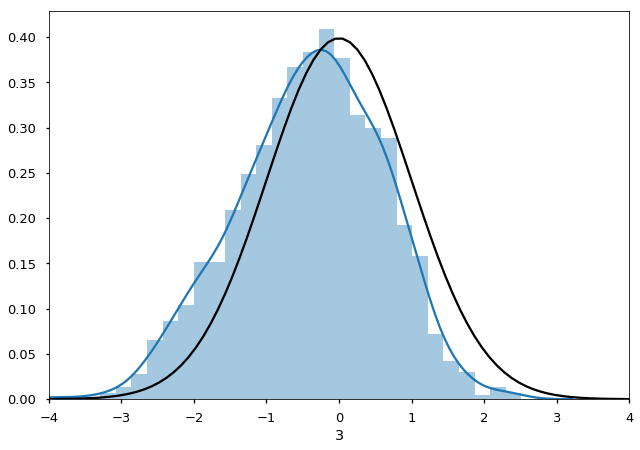

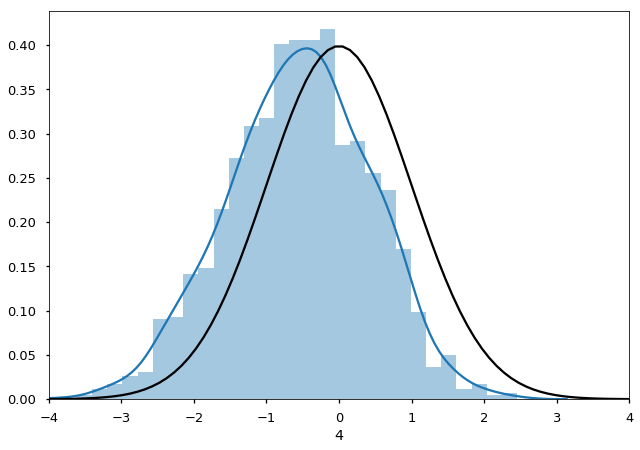

In [25]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

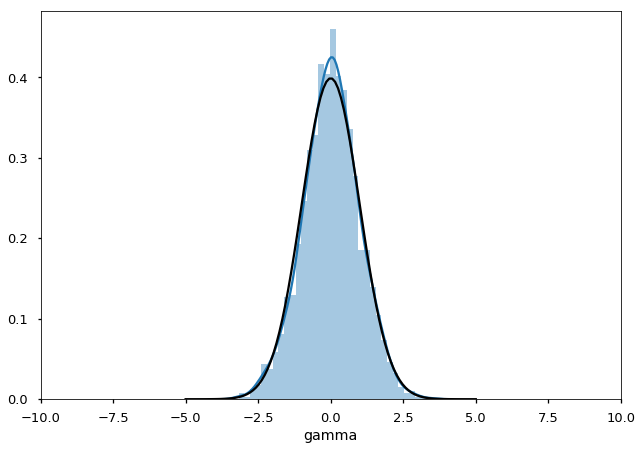

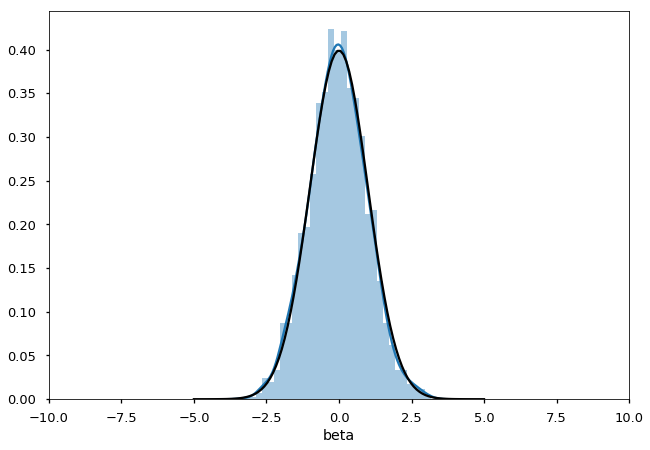

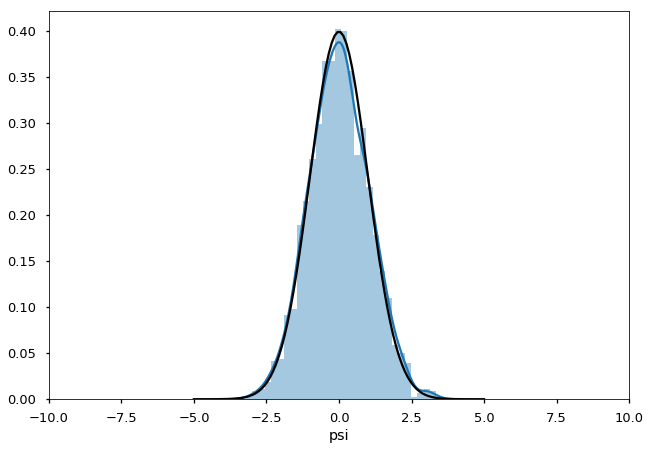

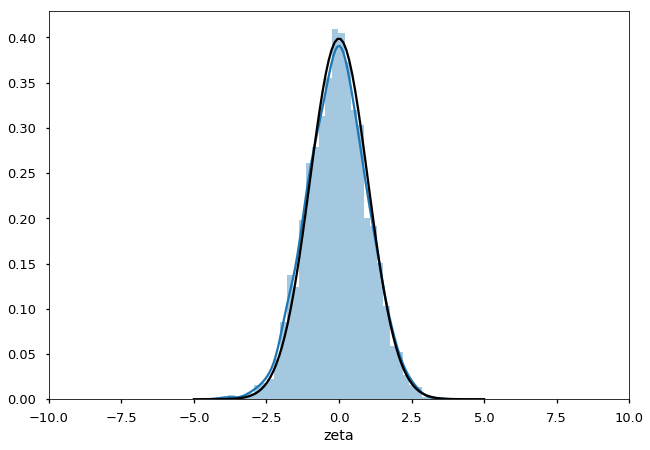

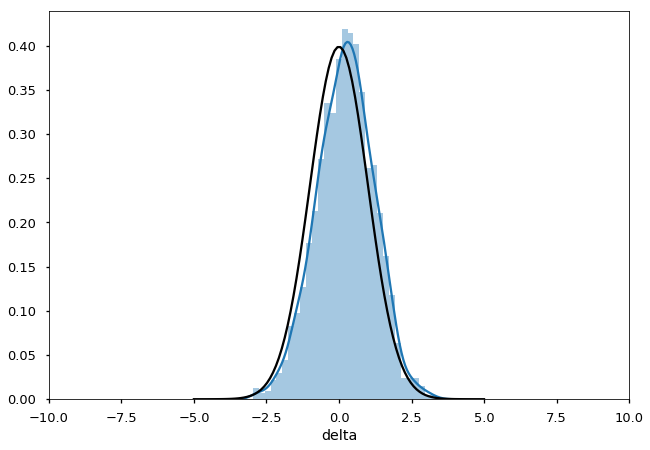

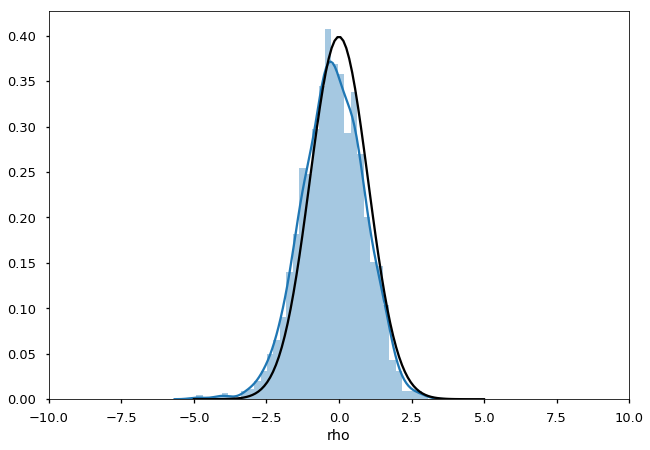

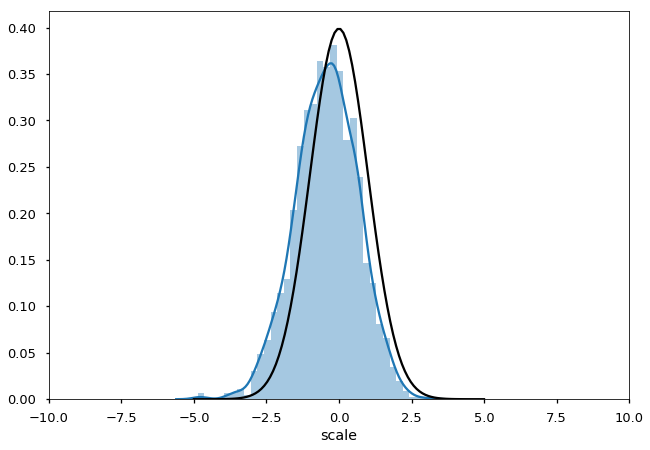

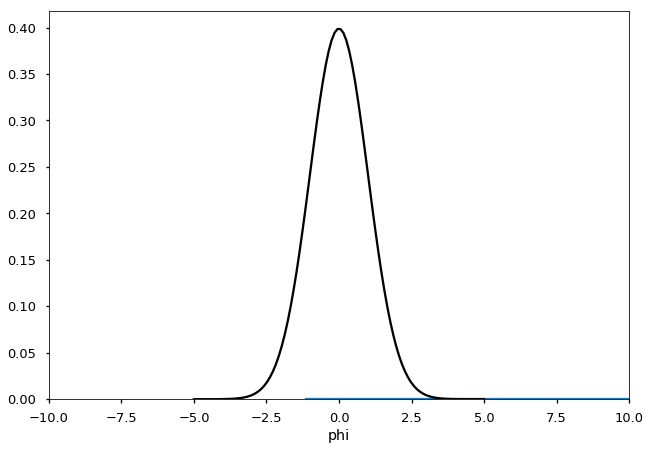

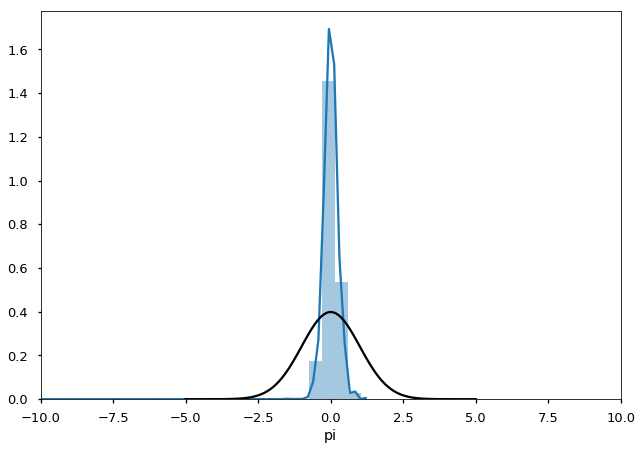

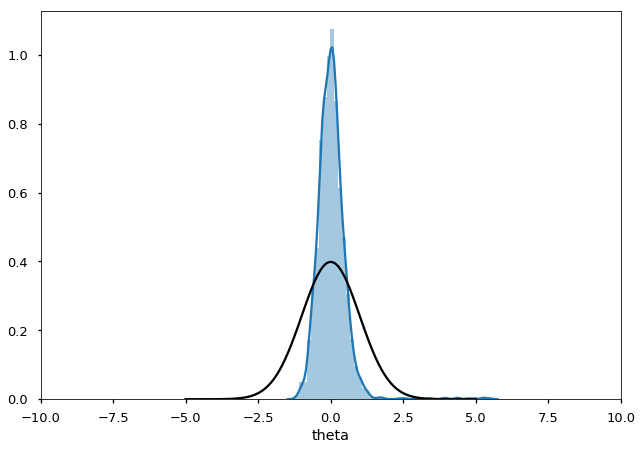

In [26]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        ax.set_xlim([-10,10])

# I now compute the robust conditional QLR statistic 

In [27]:
true_params

{'theta': 0.52,
 'pi': -0.12,
 'phi': -0.1,
 'scale': 3.12,
 'delta': 0.27,
 'rho': 0.81}

In [28]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05,
                                        robust_quantile=False)

NameError: name 'prices_init' is not defined

In [ ]:
returnval.mean()

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, rug=True, kde_kws={"color": "orange", "lw": 3},
                 hist_kws={"color":'orange'}, ax=ax4, bins=np.arange(0, returnval.robust_qlr_qauntile.max(),.5),
                label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, rug=True, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3},
            rug_kws={'color':'blue'}, label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.pdf(x, df=3) for x in xvals], color='orange', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,20])
ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)